In [12]:
import os
import os.path as osp
from model_2016 import Net_2016 
import torch
from tqdm import tqdm
import torchvision
from image_functions import *
from dataset_general import CustomDataset
import matplotlib.pyplot as plt
import numpy as np

In [77]:
# load best model
root = os.getcwd()
save_dir = osp.join(root, "saved/9-3-5-epoch_20_size_all_patches_all.pt")
model = Net_2016()
model.load_state_dict(torch.load(save_dir))
model.eval()

# set to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [78]:
def customLoss(result, target, criterion):
    """
        result: tensor
        target: tensor
    """

    result_h = result.shape[-2]
    result_w = result.shape[-1]
    target_h = target.shape[-2]
    target_w = target.shape[-1]

    assert(result_h <= target_h)
    assert(result_w <= target_w)

    h_pad = (target_h - result_h)//2
    w_pad = (target_w - result_w)//2

    if h_pad%2 or w_pad%2:
        assert("must have even padding")

    h_end = -h_pad if h_pad else result_h
    w_end = -w_pad if w_pad else result_w
    return criterion(result, target[:, :, h_pad:h_end, w_pad:w_end])

a = np.arange(25).reshape((5,5))
a = torch.from_numpy(a)
a = torch.unsqueeze(a, 0)
a = torch.unsqueeze(a, 0)

b = torch.zeros((1,1,9,9))

print(customLoss(a, b, nn.functional.mse_loss))

c = [1,2,3]
print(c[0:-0])

tensor(196.)
[]


In [79]:
def evaluate(model, datalist, criterion):
    """
    model: The NN to evaluate
    datalist: list of tuple of input, target values
    criterion: loss function

    Retuns: list of len-3 tuples given by (filename: string, outputs: tensor, loss: number)
    """
    model.eval()
    running_loss = 0.0
    running_og_loss = 0.0

    results = []
    for idx, data in enumerate(tqdm(datalist)):
        fn, inputs, labels = data

        if inputs.shape[0]==1:
            print("gray")
            inputs = inputs.expand(3, -1, -1)
            labels = inputs.expand(3, -1, -1)
        
        inputs = inputs.to(torch.float)
        labels = labels.to(torch.float)

        # add batch size component
        inputs = torch.unsqueeze(inputs, 0)
        labels = torch.unsqueeze(labels, 0)

        inputs = inputs.to(device)
        labels = labels.to(device)

        print(inputs.shape, labels.shape)

                
        # # Get model outputs and calculate loss
        outputs = model(inputs)
        print(outputs.shape)
        loss = criterion(outputs, labels)
        og_loss = criterion(inputs, labels)

        running_loss += loss
        running_og_loss += og_loss
        print('{} Original Loss: {:.4f}'.format(fn, og_loss))
        print('{} Model Loss: {:.4f}'.format(fn, loss))
        print('Running Loss: {:.4f}'.format(running_loss))

        results.append((fn, outputs, loss))
        
    print('Avg Original Loss: {:.4f}'.format(running_og_loss/len(datalist)))
    print('Avg Model Loss: {:.4f}'.format(running_loss/len(datalist)))
    return results

In [80]:
# directory of images to evaluate
root = os.getcwd()
img_dir = osp.join(root, "data/set14")

factor = 3

read_data = lambda path: torchvision.io.read_image(path) # reads into tensor
transform = lambda img: interpolate(sub_sample(torch_blur(img, 2, 9), factor), factor) # subsample down, interpolate back up
dataset = CustomDataset(img_dir, read_data, transform) # TODO: try different size_lim later
datalist = dataset.getlist()

pad = 4+1+2
results = evaluate(model, 
                   datalist, 
                   lambda result, target: customLoss(result, target, nn.functional.mse_loss)
                   )

  7%|▋         | 1/14 [00:00<00:02,  4.95it/s]

torch.Size([1, 3, 288, 351]) torch.Size([1, 3, 288, 351])
torch.Size([1, 3, 274, 337])
img_008_SRF_3_HR.png Original Loss: 223.0467
img_008_SRF_3_HR.png Model Loss: 110.1298
Running Loss: 110.1298
torch.Size([1, 3, 576, 720]) torch.Size([1, 3, 576, 720])


 21%|██▏       | 3/14 [00:01<00:04,  2.67it/s]

torch.Size([1, 3, 562, 706])
img_002_SRF_3_HR.png Original Loss: 360.8511
img_002_SRF_3_HR.png Model Loss: 270.6112
Running Loss: 380.7410
torch.Size([1, 3, 360, 249]) torch.Size([1, 3, 360, 249])
torch.Size([1, 3, 346, 235])
img_005_SRF_3_HR.png Original Loss: 863.2928
img_005_SRF_3_HR.png Model Loss: 538.2367
Running Loss: 918.9777
torch.Size([1, 3, 510, 510]) torch.Size([1, 3, 510, 510])


 29%|██▊       | 4/14 [00:01<00:03,  2.61it/s]

torch.Size([1, 3, 496, 496])
img_012_SRF_3_HR.png Original Loss: 202.5265
img_012_SRF_3_HR.png Model Loss: 92.7723
Running Loss: 1011.7500
torch.Size([1, 3, 510, 510]) torch.Size([1, 3, 510, 510])


 36%|███▌      | 5/14 [00:02<00:03,  2.45it/s]

torch.Size([1, 3, 496, 496])
img_009_SRF_3_HR.png Original Loss: 162.8269
img_009_SRF_3_HR.png Model Loss: 84.6037
Running Loss: 1096.3536
torch.Size([1, 3, 390, 585]) torch.Size([1, 3, 390, 585])


 43%|████▎     | 6/14 [00:02<00:03,  2.56it/s]

torch.Size([1, 3, 376, 571])
img_014_SRF_3_HR.png Original Loss: 595.1761
img_014_SRF_3_HR.png Model Loss: 239.7253
Running Loss: 1336.0790
torch.Size([1, 3, 510, 510]) torch.Size([1, 3, 510, 510])


 50%|█████     | 7/14 [00:02<00:02,  2.45it/s]

torch.Size([1, 3, 496, 496])
img_010_SRF_3_HR.png Original Loss: 333.5510
img_010_SRF_3_HR.png Model Loss: 212.5822
Running Loss: 1548.6611
torch.Size([1, 3, 510, 768]) torch.Size([1, 3, 510, 768])


 57%|█████▋    | 8/14 [00:03<00:03,  1.98it/s]

torch.Size([1, 3, 496, 754])
img_011_SRF_3_HR.png Original Loss: 248.4424
img_011_SRF_3_HR.png Model Loss: 113.8253
Running Loss: 1662.4865
torch.Size([1, 3, 654, 528]) torch.Size([1, 3, 654, 528])


 64%|██████▍   | 9/14 [00:04<00:02,  1.95it/s]

torch.Size([1, 3, 640, 514])
img_013_SRF_3_HR.png Original Loss: 877.5789
img_013_SRF_3_HR.png Model Loss: 492.6081
Running Loss: 2155.0945
torch.Size([1, 3, 480, 498]) torch.Size([1, 3, 480, 498])


 79%|███████▊  | 11/14 [00:04<00:01,  2.83it/s]

torch.Size([1, 3, 466, 484])
img_001_SRF_3_HR.png Original Loss: 686.6371
img_001_SRF_3_HR.png Model Loss: 532.0682
Running Loss: 2687.1626
torch.Size([1, 3, 288, 351]) torch.Size([1, 3, 288, 351])
torch.Size([1, 3, 274, 337])
img_004_SRF_3_HR.png Original Loss: 322.7869
img_004_SRF_3_HR.png Model Loss: 202.6426
Running Loss: 2889.8052
torch.Size([1, 3, 276, 276]) torch.Size([1, 3, 276, 276])


 86%|████████▌ | 12/14 [00:04<00:00,  3.56it/s]

torch.Size([1, 3, 262, 262])
img_006_SRF_3_HR.png Original Loss: 129.7950
img_006_SRF_3_HR.png Model Loss: 83.7281
Running Loss: 2973.5332
gray
torch.Size([1, 3, 510, 510]) torch.Size([1, 3, 510, 510])


 93%|█████████▎| 13/14 [00:05<00:00,  3.13it/s]

torch.Size([1, 3, 496, 496])
img_003_SRF_3_HR.png Original Loss: 0.0000
img_003_SRF_3_HR.png Model Loss: 204.0147
Running Loss: 3177.5479
torch.Size([1, 3, 360, 498]) torch.Size([1, 3, 360, 498])


100%|██████████| 14/14 [00:05<00:00,  2.62it/s]

torch.Size([1, 3, 346, 484])
img_007_SRF_3_HR.png Original Loss: 410.9584
img_007_SRF_3_HR.png Model Loss: 221.2235
Running Loss: 3398.7715
Avg Original Loss: 386.9622
Avg Model Loss: 242.7694


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(92.7723, grad_fn=<MseLossBackward0>)
torch.Size([3, 496, 496])


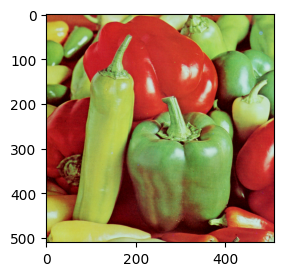

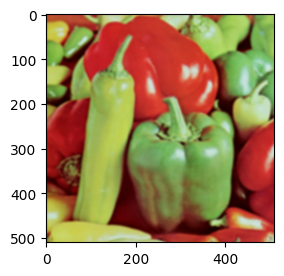

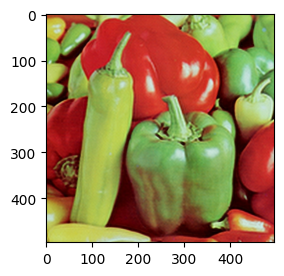

In [81]:
fn, res, loss = results[3]
fn_inp, inp, target = datalist[3]

# inp = torch.unsqueeze(inp, 0)
# print(inp.dtype, inp.shape)
target = torch.unsqueeze(target, 0)
# print(target.dtype, target.shape)

# print(customLoss(inp, target, nn.functional.mse_loss))
print(customLoss(res, target, nn.functional.mse_loss))

res = torch.squeeze(res, 0)
inp = torch.squeeze(inp, 0)
target = torch.squeeze(target, 0)
print(res.shape)

target = torch.einsum('ijk->jki', target.detach())
target = target.to(torch.int)
plt.figure(figsize=(10,6))
plt.subplot(1, 3, 1)
plt.imshow(target)

inp = torch.einsum('ijk->jki', inp.detach())
inp = inp.to(torch.int)
plt.figure(figsize=(10,6))
plt.subplot(1, 3, 2)
plt.imshow(inp)

res = torch.einsum('ijk->jki', res.detach())
res = res.to(torch.int)
plt.figure(figsize=(10,6))
plt.subplot(1, 3, 3)
plt.imshow(res)
plt.show()


model: saved/9-3-5-epoch_20_size_200_patches_100.pt

Avg Original Loss: 386.9622
Avg Model Loss: 245.9685


model: saved/9-3-5-epoch_20_size_all_patches_all.pt

Avg Original Loss: 386.9622
Avg Model Loss: 242.7694

